# Kontingenční tabulky (pivot)

Pojem `pivot` obvykle překládáme jako kontingenční tabulka. Jde o tabulku, která porovnává dvě různé tzv. kategorie - jedna kategorie je použitá pro sloupce a druhá pro řádky. Pomocí kontingenční tabulky můžeme například porovnat tržby obchodních manažerů v jednotlivých zemích.

Pro sestavení kontingenční tabulky použijeme metodu `pivot_table`. Potřebujeme nastavit následující parametry:
- Sloupec, který použijeme pro sloupce sloupcovou a řádkovou dimenzi.
- Sloupec, který využijeme pro hodnoty, a agregační funkci.

Pokud chceme porovnat tržby sales manažerů pro jednotlivé země, použijeme sloupce `sales_manager` a `country` pro sloupce a řádky. Do "vnitřku" tabulky vložíme hodnoty sloupce `contract_value` a protože chceme vidět celkovou hodnotu, jako funkci použijeme `numpy.sum`.

Abychom si výsledky výpočtů trochu zpřehlednili, můžeme vydělit hodnotu sloupce `contract_value` milionem.

In [1]:
import pandas

df_actual = pandas.read_csv("sales_actual.csv")
df_actual.head()

,date,company,country,contract_value,sales_manager
0,2021-11-09,Allard LLC Inc,Canada,374511.0,Jones Leon
1,2023-01-03,Asselin and Sons Group,Canada,170005.2,Jones Leon
2,2023-01-19,Audet Group Ltd,Canada,465253.2,Jones Leon
3,2022-07-14,Audet-Cyr Group,Canada,747392.1,Jones Leon
4,2021-02-16,Beauchamp Inc Group,Canada,140489.0,Jones Leon


Pro větší přehlednost převedeme hodnoty `contract_value` na miliony.

In [2]:
df_actual["contract_value"] = df_actual["contract_value"] / 1_000_000

Zkusme nejprve vytvořit přehledovou tabulku pomocí standardní agregace. Provedeme agregaci podle sloupců `sales_manager` a `country` a použijeme agregační funkci `sum()` pro sloupec `contract_value`.

In [3]:
df_actual_aggregated = df_actual.groupby(["sales_manager", "country"])["contract_value"].sum()
df_actual_aggregated = pandas.DataFrame(df_actual_aggregated)
df_actual_aggregated

contract_value
sales_manager country                       
Jones Leon    Canada               44.212760
              France               26.063882
              Italy                18.008563
              Netherlands          11.606895
Morgan Sarah  Canada                6.787855
              France                5.074422
              Italy                 4.047312
              Netherlands           4.009210
              USA                  23.110862
              United Kingdom       38.861613
Thomas Denise France               26.344092
              Italy                26.610211
              Netherlands          14.261435
Watts Emily   USA                   6.212289
              United Kingdom       10.289672

Nyní si zkusíme zobrazit stejnou informaci pomocí kontingenční tabulky, použijeme tedy funkci `pivot_table`.

Pozor, nepleť si funkci `pivot_table` a `pivot`! Funkci `pivot` též vytváří kontingenční tabulku, provádí však jen polovinu toho, co `pivot_table`. Přeskládá hodnoty v tabulce, ale neprovádí agregaci. Lze ji tedy použít pouze v případě, že pro každou kombinaci hodnot sloupců máš maximálně jeden záznam.

Nastavujeme následující parametry:
- `data` = tabulka, která obsahuje zdrojová data,
- `index` = sloupec sloužící jako řádková dimenze,
- `columns` = sloupec sloužící jako sloupcová dimenze,
- `values` = sloupec, ze kterého se počítají hodnoty uvnitř tabulky,
- `aggfunc` = funkce, která je použitá k výpočtu hodnot uvnitř tabulky.

In [4]:
df_actual_pivot = pandas.pivot_table(data=df_actual, values="contract_value", index="country", columns="sales_manager", aggfunc=sum, fill_value=0)
df_actual_pivot

sales_manager,Jones Leon,Morgan Sarah,Thomas Denise,Watts Emily
country,,,,
Canada,44.212760,6.787855,0.000000,0.000000
France,26.063882,5.074422,26.344092,0.000000
Italy,18.008563,4.047312,26.610211,0.000000
Netherlands,11.606895,4.009210,14.261435,0.000000
USA,0.000000,23.110862,0.000000,6.212289
United Kingdom,0.000000,38.861613,0.000000,10.289672


Často je zajímavé zobrazit si i celkový součet pro řádky a sloupce, ten získáme pomocí parametru `margins`.

In [5]:
df_actual_pivot_count = pandas.pivot_table(df_actual, values="contract_value", index="country", columns="sales_manager", aggfunc=sum, fill_value=0, margins=True)
df_actual_pivot_count

sales_manager,Jones Leon,Morgan Sarah,Thomas Denise,Watts Emily,All
country,,,,,
Canada,44.212760,6.787855,0.000000,0.000000,51.000615
France,26.063882,5.074422,26.344092,0.000000,57.482395
Italy,18.008563,4.047312,26.610211,0.000000,48.666086
Netherlands,11.606895,4.009210,14.261435,0.000000,29.877541
USA,0.000000,23.110862,0.000000,6.212289,29.323152
United Kingdom,0.000000,38.861613,0.000000,10.289672,49.151285
All,99.892099,81.891276,67.215738,16.501961,265.501075


Zkusme nyní změnit agregační funkci a uvažujme, že nás zajímá počet uzavřených kontraktů pro jednotlivé země a sales manažery. Můžeme využít například funkci `len()`, kterou známe z určování délky řetězců a seznamů.

In [6]:
pandas.pivot_table(df_actual, values="contract_value", index="country", columns="sales_manager", aggfunc=len, fill_value=0, margins=True)

sales_manager,Jones Leon,Morgan Sarah,Thomas Denise,Watts Emily,All
country,,,,,
Canada,96,14,0,0,110
France,56,12,58,0,126
Italy,38,10,63,0,111
Netherlands,27,9,30,0,66
USA,0,51,0,11,62
United Kingdom,0,85,0,22,107
All,217,181,151,33,582


### Relativní hodnoty v kontingenční tabulce

Občas mohou být zajímavější relativní hodnoty než absolutní. Uvažujme například situaci, kdy chceme vidět, kolik procent celkových tržeb v jednotlivých zemích zajistili jednotliví obchodníci. Abychom tuto informaci získali, vydělíme tržby jednotlivých obchodníků v jednotlivých zemích tržbami v celé zemi. 

Vydělení provedeme pomocí metody `div`. Výpočet spočívá v tom, že vydělíme hodnoty v řádcích tabulky součtem příslušného řádku. Proto je nutné vytvořit kontingenční tabulku s nastavením parametru `margins=True`.

In [7]:
df_actual_pivot = pandas.pivot_table(df_actual, values="contract_value", index="country", columns="sales_manager", aggfunc=sum, fill_value=0, margins=True)
df_actual_pivot_percentage = df_actual_pivot.div(df_actual_pivot.iloc[:,-1], axis=0)
df_actual_pivot_percentage

sales_manager,Jones Leon,Morgan Sarah,Thomas Denise,Watts Emily,All
country,,,,,
Canada,0.866906,0.133094,0.000000,0.000000,1.0
France,0.453424,0.088278,0.458298,0.000000,1.0
Italy,0.370043,0.083165,0.546792,0.000000,1.0
Netherlands,0.388482,0.134188,0.477330,0.000000,1.0
USA,0.000000,0.788144,0.000000,0.211856,1.0
United Kingdom,0.000000,0.790653,0.000000,0.209347,1.0
All,0.376240,0.308440,0.253166,0.062154,1.0


V tabulce například vidíme, že 96 % tržeb v Kanadě zajistil Jones Leon, 49 % tržeb ve Francii Thomas Denise atd.

Můžeme se na data podívat i z opačného úhlu a podívat se na procentuální rozdělení tržeb obchodníků v rámci zemí. K tomu potřebujeme vydělit tržby obchodníků v jednotlivých zemí celkovými tržbami jednotlivých obchodníků.

In [8]:
df_actual_pivot_percentage = df_actual_pivot.div(df_actual_pivot.iloc[-1,:], axis=1)
df_actual_pivot_percentage

sales_manager,Jones Leon,Morgan Sarah,Thomas Denise,Watts Emily,All
country,,,,,
Canada,0.442605,0.082889,0.000000,0.000000,0.192092
France,0.260920,0.061965,0.391933,0.000000,0.216505
Italy,0.180280,0.049423,0.395893,0.000000,0.183299
Netherlands,0.116194,0.048958,0.212174,0.000000,0.112533
USA,0.000000,0.282214,0.000000,0.376458,0.110445
United Kingdom,0.000000,0.474551,0.000000,0.623542,0.185127
All,1.000000,1.000000,1.000000,1.000000,1.000000


Z této tabulky vidíme, že Jones Leon zajistil třetinu svých tržeb v Kanadě a další třetinu ve Francii, Morgan Sara polovinu tržeb ve Spojeném království atd.

## Skupiny

Číselné sloupce často chceme rozdělit do skupin, například:

- zákazníky e-shopu podle počtu či hodnoty nákupů (příležitostní vs. věrní zákazníci atd.),
- univerzity dle hodnocení v žebříčku univerzit (nejlepší, skvělé, průměrné atd.),
- filmy dle hodnocení uživatelů (vynikající, průměrné, špatné atd.),
- státy dle průměrného platu (na bohaté, středně bohaté, chudé),
- studentům dle počtu bodů v testu udělíme známky.

Rozdělení můžeme provést pomocí funkce `cut`. V případě našich dat můžeme rozdělit kontrakty do několik skupin, abychom rozlišovali malé, střední a velké kontrakty. Zvolíme si například rozsahy skupin dle tabulky.

| `contract_value` | `label` |
|---|---|
| 0 až 300 000| small|
| 300 000 až 1 000 000 | medium |
| více než 1 000 000 | big |

Jako první parametr funkce `cut` zadáme sérii, ze které skupiny určujeme. Druhá skupina jsou hranice, které dělí jednotlivé skupiny. Protože máme 3 skupiny, potřebujeme 4 hranice. Jako poslední hranici můžeme zadat nějakou hodně vysokou částku (např. miliardu), případně můžeme použít výraz `inf`, což je zkratka anglického infinity - nekonečno. Řetězec `"inf"` převedeme na desetinné číslo pomocí funkce `float()`. Jako parametr `labels` přidáme seznam s názvy skupin.

In [9]:
df_actual["group"] = pandas.cut(df_actual["contract_value"], [0, 300_000, 1_000_000, float("inf")], labels=["small", "medium", "big"])
df_actual.head()

,date,company,country,contract_value,sales_manager,group
0,2021-11-09,Allard LLC Inc,Canada,0.374511,Jones Leon,small
1,2023-01-03,Asselin and Sons Group,Canada,0.170005,Jones Leon,small
2,2023-01-19,Audet Group Ltd,Canada,0.465253,Jones Leon,small
3,2022-07-14,Audet-Cyr Group,Canada,0.747392,Jones Leon,small
4,2021-02-16,Beauchamp Inc Group,Canada,0.140489,Jones Leon,small


## Dobrovolné čtení na doma

### Teplotní mapa

I kontingenční tabulku můžeme prezentovat jako graf, hodí se například graf typu teplotní mapa (Heat Map). Ten vypadá podobně jako kontingenční tabulka, hodnoty jsou ale podbarveny barevnou škálou. Vygenerování grafu modulem `matplotlib` je poměrně náročné, proto je v tomto případně lepší použít "nadstavbu", kterou je modul `seaborn`. Před spuštěním program je potřeba modul nainstalovat příkazem

```
pip install seaborn
```

<AxesSubplot:xlabel='sales_manager', ylabel='country'>

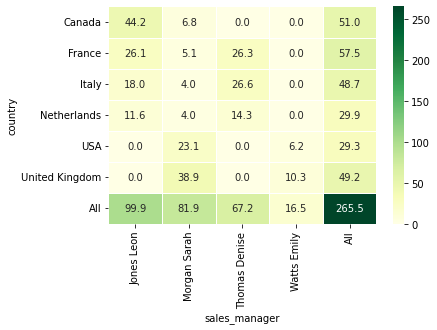

In [10]:
import seaborn as sns
sns.heatmap(df_actual_pivot, annot=True, fmt=".1f", linewidths=.5, cmap="YlGn")